In [8]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
import seaborn as sns

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots#, find_net_benefit, find_net_benefit_min_negatives
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

ImportError: cannot import name 'add_labels_to_subplotsfind_net_benefit' from 'Functions' (/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py)

# Load data

In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Parameters needed for trainig and CV

In [6]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
weeks_to_predict = range(1,120)

In [9]:
import os
import pickle
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, matthews_corrcoef

new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_model_no_cases/'
os.chdir(new_directory)

net_benefit_by_omega_p_full_period = {}
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(
        HSA_weekly_data_all, 
        no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), 
        weeks_in_future=3, 
        geography='HSA_ID', 
        weight_col='weight', 
        keep_output=True
    )

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(
        HSA_weekly_data_all, 
        no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), 
        weeks_in_future=3, 
        geography='HSA_ID', 
        weight_col='weight', 
        keep_output=True
    )
    
    weights_full_period = weights_full[0].to_numpy()

    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
    y_pred_positive_proba = y_pred_proba[:, 1] 

    #net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_full, omega_sequences, threshold_sequences)
    #net_benefit_by_omega_p_full_period[prediction_week] = net_benefit_by_omega_week_period

    ROC_by_week_full_period.append(roc_auc_score(y_test_full, y_pred_positive_proba))
    conf_matrix = confusion_matrix(y_test_full, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_full_period.append(sensitvity)
    specificity_by_week_full_period.append(specificity)
    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

    accuracy_by_week_full_period.append(accuracy_score(y_test_full, y_pred))
    norm_MCC_by_week_full_period.append((matthews_corrcoef(y_test_full, y_pred) + 1) / 2)



NameError: name 'percent_exceed_capacity' is not defined

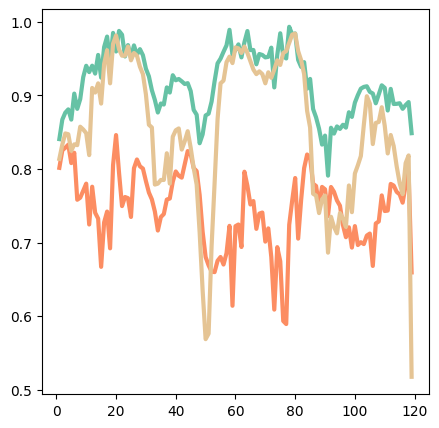

In [10]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey = 'all')

axs.plot(weeks_to_predict[0:len(ROC_by_week_full_period)], ROC_by_week_full_period, label='auROC', linewidth=3, color=palette[0])
axs.plot(weeks_to_predict[0:len(norm_MCC_by_week_full_period)], norm_MCC_by_week_full_period, label='MCC', linewidth=3, color=palette[1])
axs.plot(weeks_to_predict[0:len(accuracy_by_week_full_period)], accuracy_by_week_full_period, label='Accuracy', linewidth=3, color=palette[5])
axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs.set_xlabel('Weeks after 2020-07-15', **hfont, fontsize=18)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.set_ylim(0.17,1)



axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')